# Final Models Evaluation with Wild Fire Data

This notebooks will tune and run 3-4  classifiers on wildfire dataset in order to make a predecction on fire intensity. ExtraTrees, RandomForest, Bagging and Adaboost (optional).

This will be a binary classification, predict moderate to severe fires.
Original goal was to predict 4 categories but the classifiers and lack of data on Severe fires 
made predictions not reliable. 

In [1]:
#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

In [2]:
#optional code to ensure everyone is on the right version
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 0.23.1.


# Import all the models and libraries needed

In [3]:
%matplotlib inline

import os
import pickle
import pandas as pd
import numpy as np
import collections
import seaborn as sns

from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler

from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import CVScores
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ClassificationReport

from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as smotePipeline





# Helper functions to save and open estimator
Saves to current working directory

In [4]:
def save_estimator (estimator) :
          
    outpath = estimator.__class__.__name__.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)
        f.close()
        

In [5]:
def open_estimator(filename) :
    
    infile = open(filename,'rb')
    estimator = pickle.load(infile)
    infile.close()

    print ("Unpickled file", filename)
    
    return estimator

### Read the Fire Data From Disk to Save Time.
During the feature evaluation the data was pulled from the database and stored locally
Read a random sample.

Optimal testing data is 150K - 200K

In [6]:
df_fires = pd.read_csv('data/FireIntensity_Model_June12_Clean.csv') #.sample(500000)

print(df_fires.shape)

(1328922, 26)


### Assess data in the file. 
Check data to ensure it's correct.


In [7]:
# Expanding number of columns:
pd.set_option('display.max_columns', 40)

In [8]:
# review datagram
print (df_fires.shape)
df_fires.head() 

(1328922, 26)


,Unnamed: 0,latitude,longitude,doy,month,year,cluster_reference,fire_region,season,covertype,fuelcode,prefire_fuel,fuel_moisture_class,temperature,humidity,precip_intensity,visibility,wind_speed,wind_gust,brightness,fire_intensity,fire_intensity_twocat,fire_intensity_threecat,fire_intensity_fourcat,bright_t31,frp
0,0,34.5954,-78.6218,1,1,2003,2003_4279,6,3,3,1600,6220.097576,3,64.14,0.88,0.011,9.022000,6.42,12.51,306.5,Low,Moderate,Low,Low,289.2,11.0
1,1,33.4182,-110.8618,1,1,2003,2003_1522,4,3,3,1220,4534.187262,2,32.17,0.37,0.000,9.216293,6.88,18.50,307.6,Low,Moderate,Low,Low,285.1,10.8
2,2,29.7120,-95.1284,1,1,2003,2003_919,3,3,1,1,277.412850,2,65.97,0.50,0.000,9.997000,10.98,16.90,307.2,Low,Moderate,Low,Low,294.1,5.6
3,3,28.9161,-98.6293,1,1,2003,2003_777,3,3,1,1,251.296812,2,72.89,0.51,0.000,9.997000,25.06,28.59,313.3,Medium,Moderate,Low,Low,297.4,12.0
4,4,32.7772,-95.0444,1,1,2003,2003_3100,3,3,1,1,173.172870,2,58.39,0.30,0.000,9.216293,7.99,10.99,301.3,Low,Moderate,Low,Low,289.9,4.2


### Drop the columns not needed identified during the feature seleciton phase
Recommend Features:  'latitude', 'longitude', 'doy', 'temperature', 'wind_speed','humidity', 'fire_region', 'season', 
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                 'visibility', 'precip_intensity', 'wind_gust'

In [9]:
df_fires = df_fires.drop(columns={'Unnamed: 0','cluster_reference', 'fire_region', 'season', 
                                  'month', 'year', 'brightness', 'bright_t31','frp', 'visibility', 'covertype',
                                  'fire_intensity', 'fire_intensity_threecat', 'fire_intensity_fourcat'})

In [10]:
df_fires.columns

Index(['latitude', 'longitude', 'doy', 'fuelcode', 'prefire_fuel',
       'fuel_moisture_class', 'temperature', 'humidity', 'precip_intensity',
       'wind_speed', 'wind_gust', 'fire_intensity_twocat'],
      dtype='object')

### Shape shows imbalanced data. We will under sample later to balance the data.

In [11]:
#show the shape of the data
print(df_fires['fire_intensity_twocat'].value_counts())

Moderate    1311429
Severe        17493
Name: fire_intensity_twocat, dtype: int64


### Setup the features for the pipeline

In [12]:
def find_X_y(df_fires1):

    #
    features = ['latitude', 'longitude', 'doy','fuelcode', 'fuel_moisture_class', 'prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 'wind_gust',
                'wind_speed']


    # four categories using balanced binning
    #target = ['fire_intensity_fourcat']
    target = ['fire_intensity_twocat']
    
    y = df_fires1[target]
    y = np.ravel(y)
    X = df_fires1[features]
    
    # Not really needed already 1-4 numerical
    #y = LabelEncoder().fit_transform(y) # Label-encode targets before modeling
    
    return X, y



In [13]:
X, y = find_X_y(df_fires)
X.shape

(1328922, 11)

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

# Define the models to test
<b>Down to our best 3 </b>
Adaboost is optional given time.
Set the parameters from the hyperparameter evaluation. 
defaults seems to work best.

In [14]:
models = [     
            ExtraTreesClassifier(n_estimators=10),
            #ExtraTreesClassifier(bootstrap=True, max_depth=10, n_jobs=-1, oob_score=True),
            RandomForestClassifier(n_estimators=10),
            #RandomForestClassifier(criterion='entropy', max_depth=10, n_jobs=-1,
                       #oob_score=True),
            #BaggingClassifier( max_features=1, max_samples=1,
                  #n_estimators=5, n_jobs=-1, oob_score=True), 
            BaggingClassifier(n_estimators=10), 
            #AdaBoostClassifier(learning_rate=0.1, n_estimators=5)
            AdaBoostClassifier(n_estimators=10)
        ]    


### Data Imbalance
We have a massive data imbalanced, tried a combination or oversampling, undersampling and both combined.
Undersampling produced the best results with a lil bit over oversampling. Still imbalance but much less after
undersampling. 

In [15]:
def smote_data(X, y):
    
    over_sample = {'Severe': 35000}
    over = SMOTE(sampling_strategy = over_sample)
    X, y = over.fit_resample(X,y)
    
    under_range = {'Moderate' : 150000} #recommend hyperparameter range - 150-200k
    under = RandomUnderSampler(sampling_strategy=under_range)
    X, y = under.fit_resample(X,y)
    
    return X, y

In [16]:
collections.Counter(y)


Counter({'Moderate': 1311429, 'Severe': 17493})

In [17]:
X, y = smote_data(X, y)

In [18]:
collections.Counter(y)


Counter({'Moderate': 150000, 'Severe': 35000})

In [19]:
X.shape

(185000, 11)

# Function to Fit and predict the scores of the model. 
Give us our final scores

In [20]:
def score_model(X, y, estimator, **kwargs):
   

    #define category features to be one hot encoded
    cat_features = ['fuelcode', 'fuel_moisture_class']
     
    #define numeric features for scaling
    num_features = ['longitude', 'latitude', 'doy', 'prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 'wind_gust', 'wind_speed']
    
    #setup simple one hot encoder
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('imputer', SimpleImputer(strategy='most_frequent'))])

    #setup basic scaler
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler()),
        ('imputer', SimpleImputer(strategy='median'))])


    # Setting the transformation for the pipeline below. 
    preprocessor = ColumnTransformer (transformers=[
        ('num_features', numeric_transformer, num_features),
        ('cat_features', categorical_transformer, cat_features)])
    
   
    #setup the pipeline
    model = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('estimator', estimator)
      ])
    
    
     # Train the model on the smote data
    model.fit(X, y, **kwargs) 

    #Get new non smote data to test the model
    df_fires1 = pd.read_csv('data/FireIntensity_Model_June12_Clean.csv').sample(50000)
    X1, y1 = find_X_y(df_fires1)
    
    #testing against note smote dataset
    expected = y1
    predicted = model.predict(X1)
    
    
     # Compute and return F1 harmonic mean and average
    print("{}: {}".format(estimator.__class__.__name__ + " : Original data F1 Micro Score ", f1_score(expected, predicted, average='micro')))
    print("{}: {}".format(estimator.__class__.__name__ + " : Original data F2 Macro Score ", f1_score(expected, predicted, average='macro')))
    
    
    print(classification_report(expected, predicted))
    


    #save estimator to disk
    save_estimator(model)
    



### Class Prediction Error

In [21]:

def class_pred_error (X1,y1, model1):


    classes=['Moderate', 'Severe']

    # Perform 80/20 training/test split
    X_train, X_test, y_train, y_test = tts(
        X1, y1, test_size=0.20, random_state=42
    )
    
    visualizer = ClassPredictionError(
        model1, 
        classes=classes, size=(1080, 720)
    )
    #model.fit(X,y)

    # Fit the training data to the visualizer
    visualizer.fit(X, y)

    # Evaluate the model on the test data
    visualizer.score(X_test, y_test)

    # Draw visualization
    visualizer.show()



### Function to run cross validate models against the data

In [22]:
def cross_val_score(X1, y1, model): 
    
    #Create a cross-validation strategy
    cv = StratifiedKFold(n_splits=10, random_state=42)

    # Instantiate the classification model and visualizer
    visualizer = CVScores(model, cv=cv, scoring='f1_weighted')

    visualizer.fit(X1, y1)        # Fit the data to the visualizer
    visualizer.show()           # Finalize and render the figure
    
    
   

###  Print the classifcation report

In [23]:
def visualize_model_report(X1, y1, model1, **kwargs):

    X_train, X_test, y_train, y_test = tts(X1, y1, test_size=0.20)

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model1,
        classes=['Moderate', 'Severe'], # Classes for equal balanced bins per quartiles
        cmap="Reds", 
        support=True,
        size=(800, 660)
    )

    # Train the model on the smote data
    #model1.fit(X, y, **kwargs) 

    visualizer.fit(X, y)  
        
    visualizer.score(X_test, y_test)

    visualizer.show()
    
   
    


### Print the confusion matrix

In [24]:
def confusion_matrix_report (X1, y1, model1, **kwargs):

    X_train, X_test, y_train, y_test = tts(X1, y1, test_size=0.20)
    
    
    # Instantiate the classification model and visualizer
    model1.fit(X, y, **kwargs)  
    
    # The ConfusionMatrix visualizer taxes a model
    cm = ConfusionMatrix(model1, classes=['Moderate','High'])

    # Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
    cm.fit(X, y)

    # To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
    # and then creates the confusion_matrix from scikit-learn.
    cm.score(X_test, y_test)


    cm.show()
    
 


### Show the ROCAUC Curve

In [25]:
def roc_curve (X, y, model1):

    # Instantiate the classification model and visualizer
    classes=['Moderate', 'Severe']
    visualizer = ROCAUC(model1, classes=classes, size=(1080, 720))
                                           
    # Create the train and test data
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3)


    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()                 # Draw the data


### Get real data - test the model against non synthentic data

In [26]:
#get non smote data to test with
df_fires2 = pd.read_csv('data/FireIntensity_Model_June12_Clean.csv').sample(50000)
X2, y2 = find_X_y(df_fires2)



### Test the first classifier ExtraTrees
Resuts are it detects moderate and high well but low precision means it will misclassify 
severe with false negatives

ExtraTreesClassifier : Original data F1 Micro Score : 0.9582
ExtraTreesClassifier : Original data F2 Macro Score : 0.6852221492419566
              precision    recall  f1-score   support

    Moderate       1.00      0.96      0.98     49326
      Severe       0.24      1.00      0.39       674

    accuracy                           0.96     50000
   macro avg       0.62      0.98      0.69     50000
weighted avg       0.99      0.96      0.97     50000



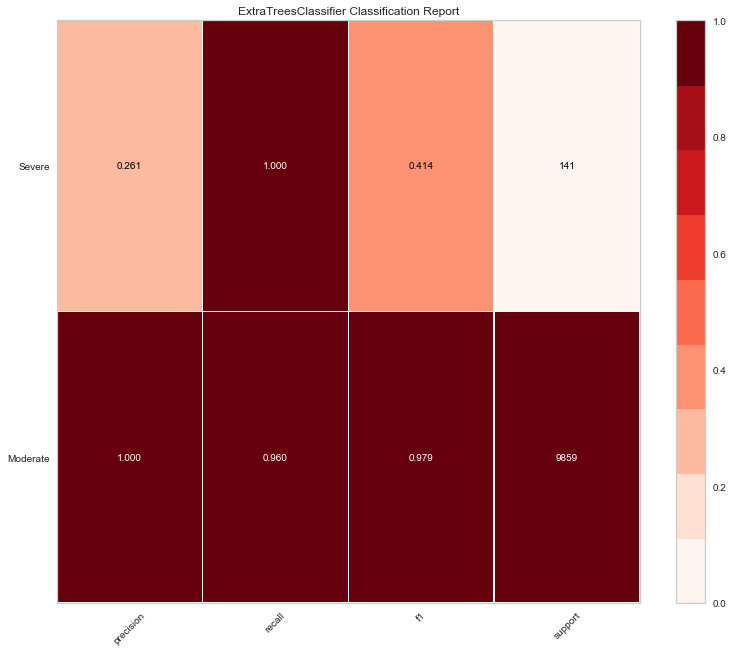

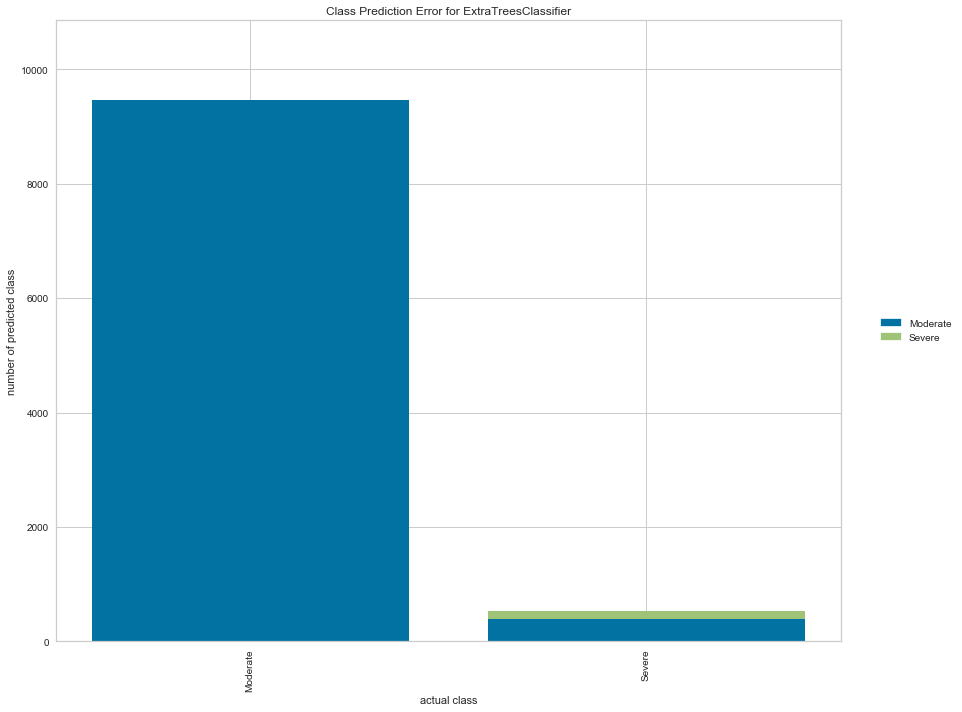

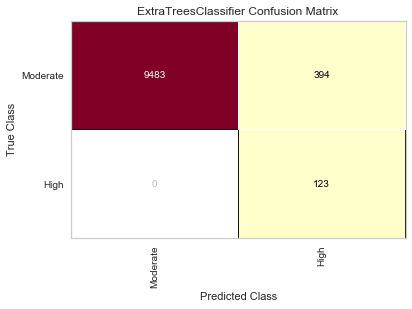

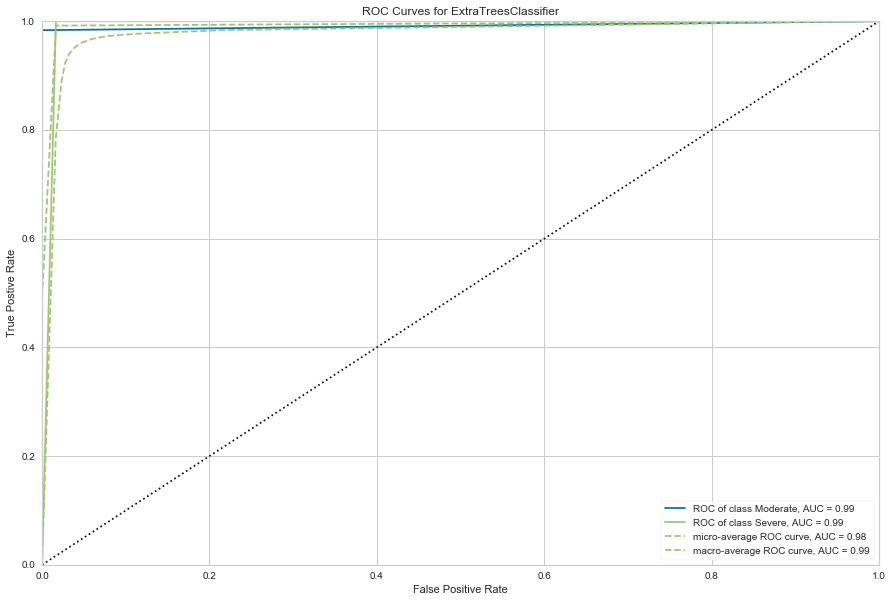

In [27]:

mod = models[0]

#F1 Score
score_model(X, y, mod)

#fit the model for the rest of the reports
mod.fit(X,y)

#Classification Report
visualize_model_report(X2, y2, mod)

#class Prediction Eror
class_pred_error(X2, y2, mod)

#Confusion Report
confusion_matrix_report(X2, y2, mod)

#Learning Curve
roc_curve(X2, y2, mod)




### Test RandomForest

RandomForestClassifier : Original data F1 Micro Score : 0.95932
RandomForestClassifier : Original data F2 Macro Score : 0.6792351765554561
              precision    recall  f1-score   support

    Moderate       1.00      0.96      0.98     49339
      Severe       0.24      0.94      0.38       661

    accuracy                           0.96     50000
   macro avg       0.62      0.95      0.68     50000
weighted avg       0.99      0.96      0.97     50000



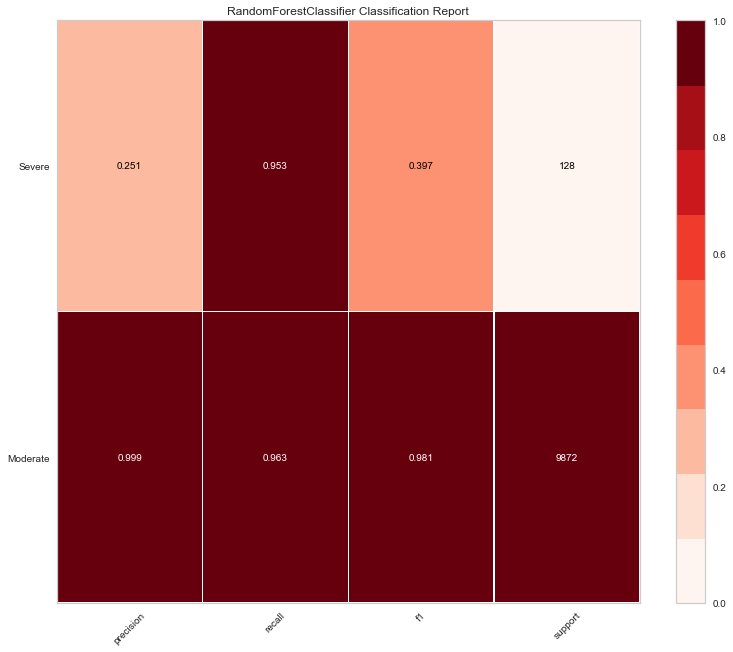

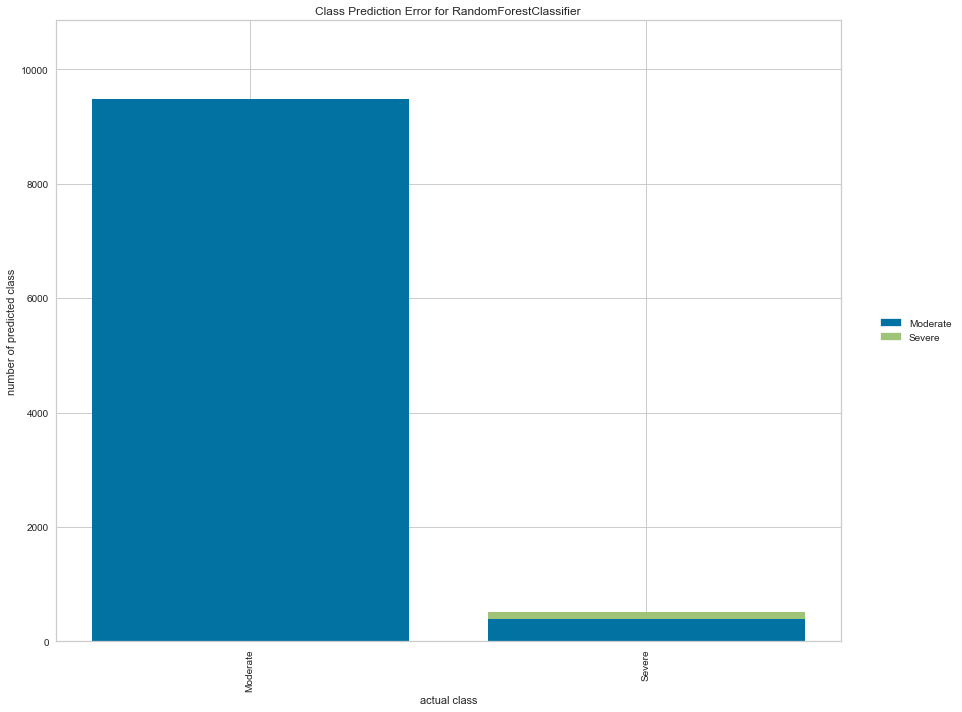

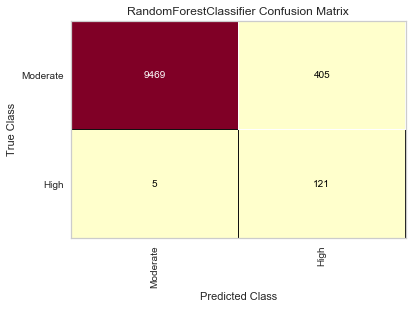

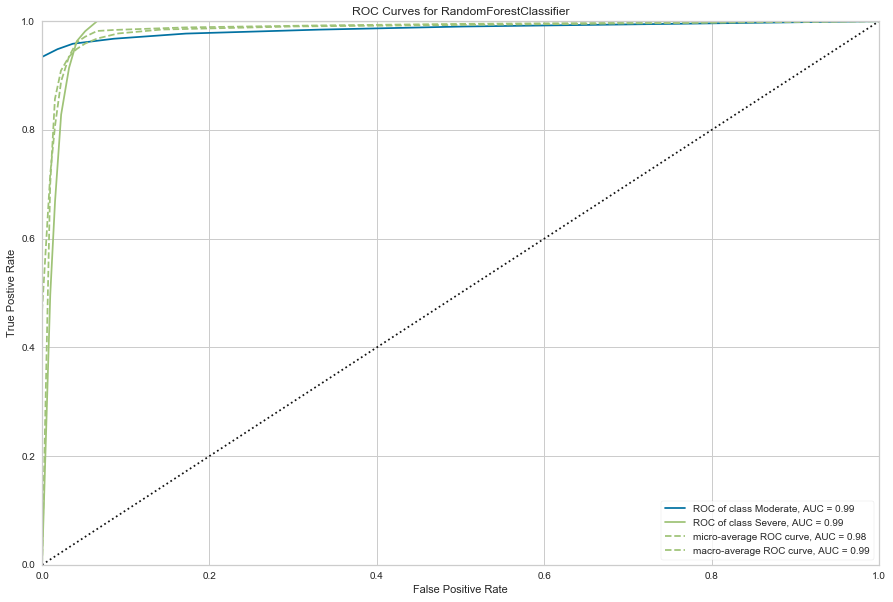

In [28]:

mod = models[1]

#F1 Score
score_model(X, y, mod)

mod.fit(X, y)

#Classification Report
visualize_model_report(X2, y2, mod)

#class Prediction Eror
class_pred_error(X2, y2, mod)

#Confusion Report
confusion_matrix_report(X2, y2, mod)

#Learning Curve
roc_curve(X2, y2, mod)

### Test BaggingClassifier 

BaggingClassifier : Original data F1 Micro Score : 0.95942
BaggingClassifier : Original data F2 Macro Score : 0.6793621341231575
              precision    recall  f1-score   support

    Moderate       1.00      0.96      0.98     49349
      Severe       0.24      0.95      0.38       651

    accuracy                           0.96     50000
   macro avg       0.62      0.96      0.68     50000
weighted avg       0.99      0.96      0.97     50000



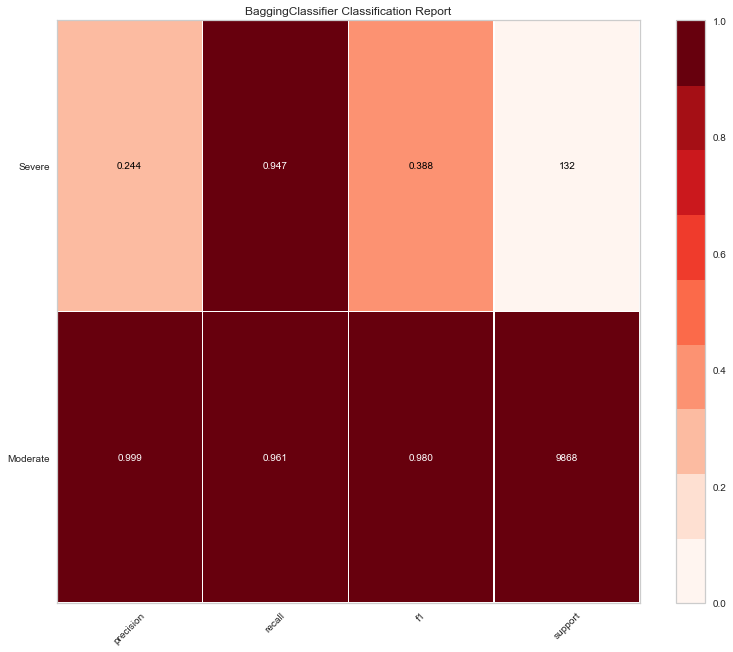

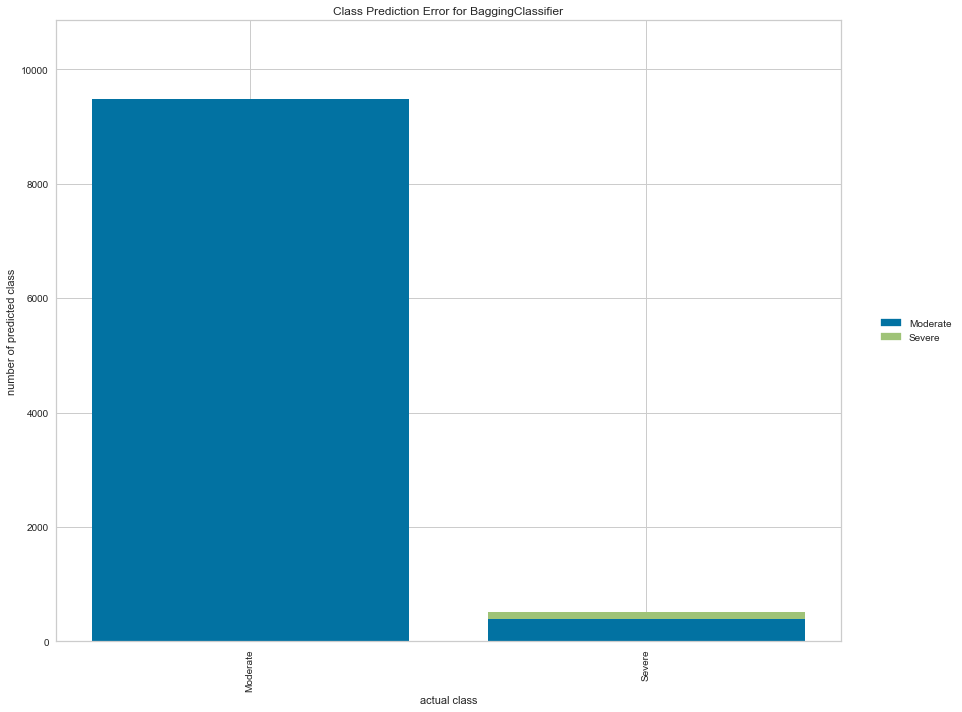

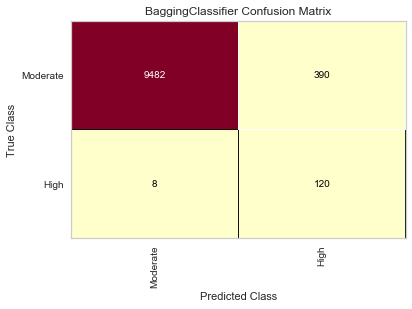

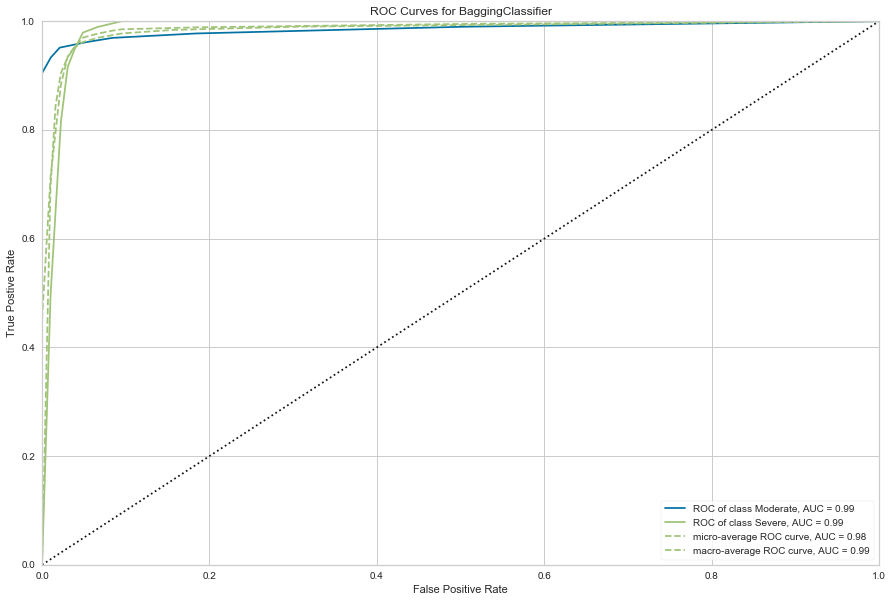

In [29]:

mod = models[2]

#F1 Score
score_model(X, y, mod)

mod.fit(X, y)

#Classification Report
visualize_model_report(X2, y2, mod)

#class Prediction Eror
class_pred_error(X2, y2, mod)

#Confusion Report
confusion_matrix_report(X2, y2, mod)

#Learning Curve
roc_curve(X2, y2, mod)

### Test AdaBoost Classifier 


AdaBoostClassifier : Original data F1 Micro Score : 0.93106
AdaBoostClassifier : Original data F2 Macro Score : 0.5250490259772389
              precision    recall  f1-score   support

    Moderate       0.99      0.94      0.96     49396
      Severe       0.05      0.27      0.09       604

    accuracy                           0.93     50000
   macro avg       0.52      0.60      0.53     50000
weighted avg       0.98      0.93      0.95     50000



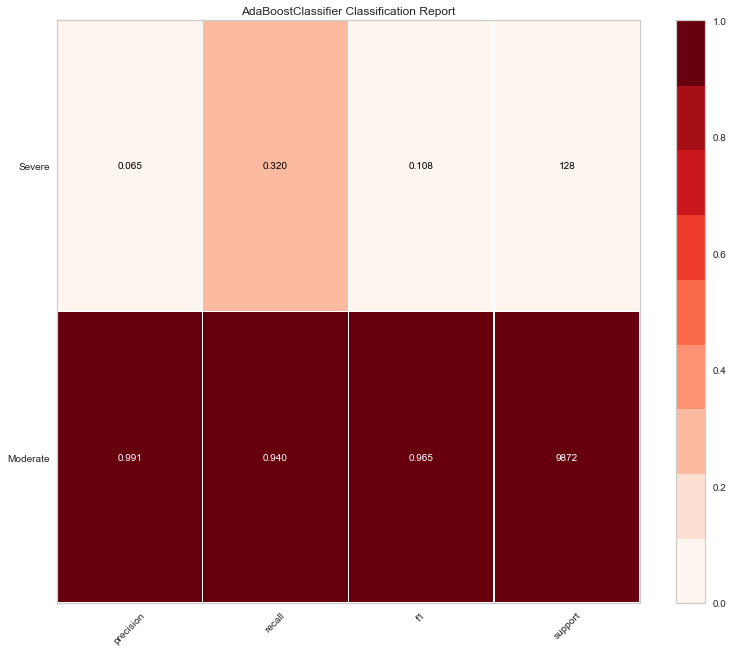

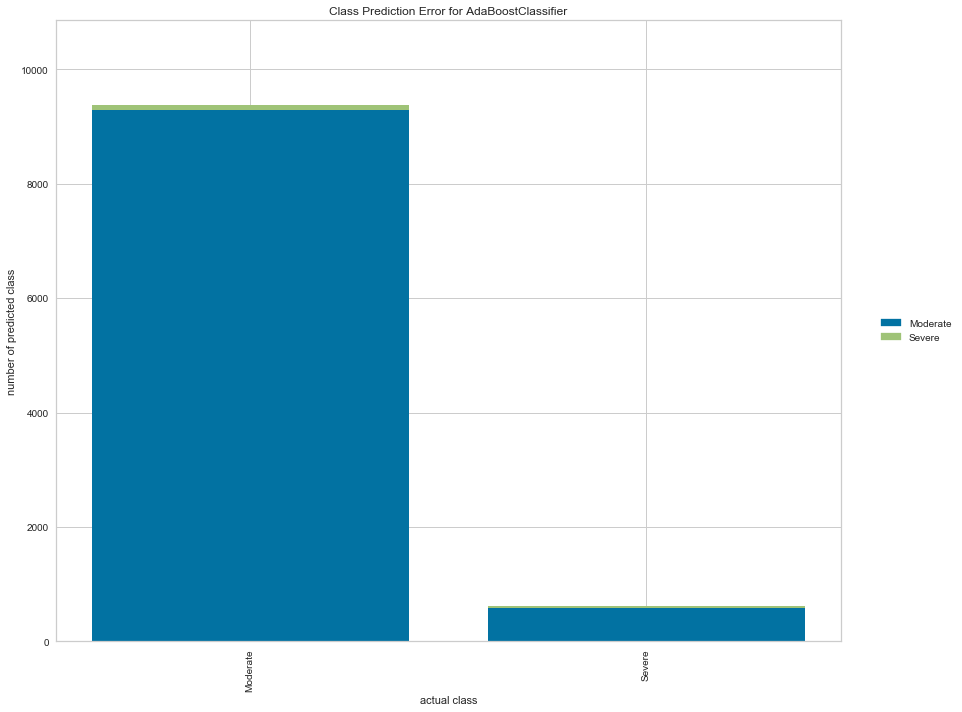

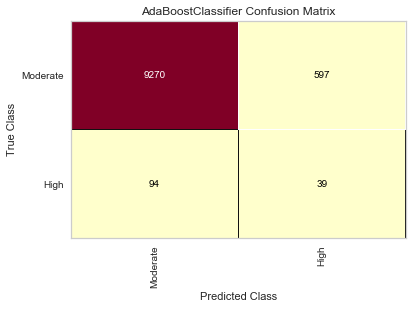

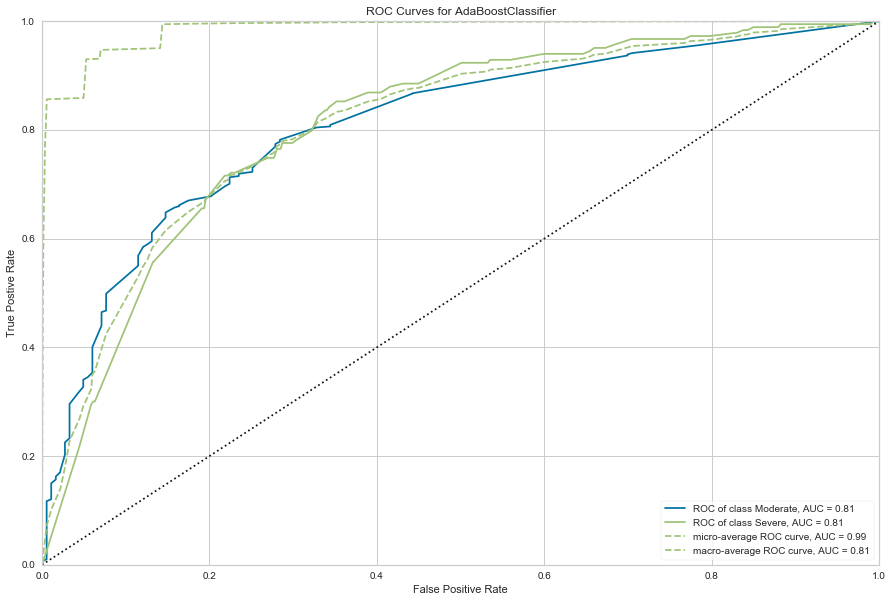

In [30]:

mod = models[3]

#F1 Score
score_model(X, y, mod)

mod.fit(X, y)

#Classification Report
visualize_model_report(X2, y2, mod)

#class Prediction Eror
class_pred_error(X2, y2, mod)

#Confusion Report
confusion_matrix_report(X2, y2, mod)

#Learning Curve
roc_curve(X2, y2, mod)

### ROCAUC Curve

### Examine Class Prediction Error

### Final Summary
ExtraTrees Classifier yeilds a slight better F1 score and is slightly faster to run over over the other alogirthms.
These are all complex ensemble classifier but ExtraTrees is probably the simple of them.

Final conclusion use extra tree since it has a high recall on severe fires though the precision is low. 


